<a href="https://colab.research.google.com/github/9characters/RL_repo/blob/master/DQN_Tips_%26_Tricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys

# Checks that the Runtime is correct
if 'google.colab' in sys.modules:
    !nvidia-smi | grep -q 'failed' && echo "STOP! You are using a runtime without a GPU. Change the runtime type before going further!"

In [0]:
import sys

# Setup for use in Colab
# Your Runtime will crash after this - this is normal!
# Resume from next cell after it restarted
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone https://github.com/AIcrowd/droneRL-workshop
        
    # Install packages via pip
    !pip install -r "droneRL-workshop/colab-requirements.txt"
    
    # Restart Runtime so everything takes effect
    import os
    os.kill(os.getpid(), 9)

Cloning into 'droneRL-workshop'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 648 (delta 49), reused 61 (delta 19), pack-reused 543
Receiving objects: 100% (648/648), 15.03 MiB | 15.66 MiB/s, done.
Resolving deltas: 100% (375/375), done.
     |████████████████████████████████| 1.6MB 7.6MB/s 
     |████████████████████████████████| 2.1MB 44.2MB/s 
     |████████████████████████████████| 225kB 42.3MB/s 
     |████████████████████████████████| 13.1MB 240kB/s 
     |████████████████████████████████| 10.4MB 58.7MB/s 
     |████████████████████████████████| 20.0MB 1.2MB/s 
     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 41.6MB/s 
     |████████████████████████████████| 1.0MB 56.1MB/s 
  Created wheel for gym: filename=gym-0.15.4-cp36-none-any.whl size=1648483 sha256=f90f1c730a86aa16acaaa6d649f041bf52af3d82dc785f09f7fc7ce6425f0bc4
  

In [3]:
%cd droneRL-workshop

/content/droneRL-workshop


Training multiple agents at once
---

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import datetime
import os
import numpy as np

from agents.dqn import DQNAgent, ConvQNetworkFactory, ConvQNetwork
from agents.random import RandomAgent
from agents.logging import TensorBoardLogger, NoLogger
from env.env import DeliveryDrones
from env.wrappers import WindowedGridView
from helpers.rl_helpers import MultiAgentTrainer, test_agents, plot_cumulative_rewards, plot_rolling_rewards, render_video

In [0]:
env = WindowedGridView(DeliveryDrones(), radius=3)

# Default parameters used for evaluation
env.env_params.update({
    'charge': 20,
    'charge_reward': -0.1,
    'crash_reward': -1,
    'delivery_reward': 1,
    'discharge': 10,
    'drone_density': 0.05,
    'dropzones_factor': 2,
    'n_drones': 10,
    'packets_factor': 3,
    'pickup_reward': 0,
    'rgb_render_rescale': 1.0,
    'skyscrapers_factor': 3,
    'stations_factor': 2
})

In [0]:
# Setup Tensorboard - wait a bit after running this
%reload_ext tensorboard

In [15]:
# Show Tensorboard. It will take time to appear and will initially be empty
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 288), started 0:10:23 ago. (Use '!kill 288' to kill it.)

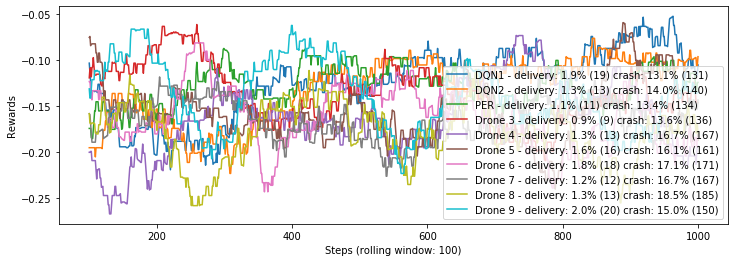

In [8]:
# Setup TensorBoard loggers
tb_logger_1 = TensorBoardLogger(os.path.join('logs', 'dqn1'), datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
tb_logger_2 = TensorBoardLogger(os.path.join('logs', 'dqn2'), datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
tb_logger_3 = TensorBoardLogger(os.path.join('logs', 'dqn3'), datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

# Create 3 DQN agents with different hyper-parameters and TensorBoard logging
dqn_agent_1 = DQNAgent(
    env, ConvQNetworkFactory(env, conv_layers=[
        {'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
    ], dense_layers=[256]),
    gamma=0.95, epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01, memory_size=10000, batch_size=64, 
    target_update_interval=500, logger=tb_logger_1)

dqn_agent_2 = DQNAgent(
    env, ConvQNetworkFactory(env, conv_layers=[
        {'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1},
        {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1}
    ], dense_layers=[64, 64]),
    gamma=0.99, epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01, memory_size=10000, batch_size=64, 
    target_update_interval=500, logger=tb_logger_2)

dqn_agent_3 = DQNAgent(
    env, ConvQNetworkFactory(env, conv_layers=[
        {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1}
    ], dense_layers=[16, 16]),
    gamma=0.99, epsilon_start=1, epsilon_decay=0.99, epsilon_end=0.01, memory_size=10000, batch_size=64, 
    target_update_interval=500, logger=tb_logger_3)

# Reset environment with those parameters
env.reset()

# Setup random opponents
agents = {drone.index: RandomAgent(env) for drone in env.drones}

# Add the RL drones
agents[0] = dqn_agent_1
agents[1] = dqn_agent_2
agents[2] = dqn_agent_3

# Create trainer
trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)

# Let's train!
trainer.train(1000)
rewards = plot_rolling_rewards(trainer.rewards_log, drones_labels={0: 'DQN1', 1: 'DQN2', 2: 'PER'})



In [11]:
trainer.train(10000)

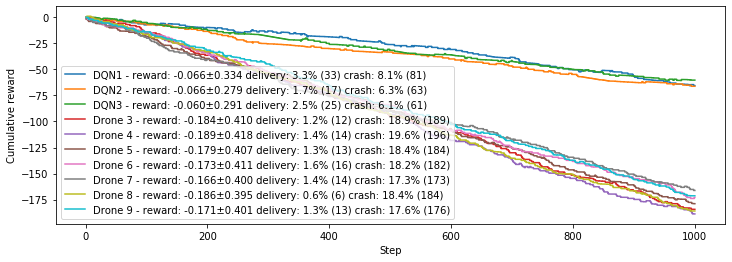

Final scores:
Agent 0: -65.60000000000001
Agent 1: -66.20000000000002
Agent 2: -60.300000000000004
Agent 3: -184.29999999999998
Agent 4: -188.7
Agent 5: -178.90000000000003
Agent 6: -172.9
Agent 7: -166.2
Agent 8: -185.9
Agent 9: -171.3


In [12]:
# Evaluation
rewards_log = test_agents(env, agents, n_steps=1000)
plot_cumulative_rewards(rewards_log, drones_labels={0: 'DQN1', 1: 'DQN2', 2: 'DQN3'})

print('Final scores:')
for idx, score in enumerate(np.sum(list(rewards_log.values()), axis=1)):
    print("Agent {}: {}".format(idx, score))

In [0]:
# Save the agents you want
dqn_agent_1.save(os.path.join('output', 'agents', 'dqn-agent-1.pt'))
dqn_agent_2.save(os.path.join('output', 'agents', 'dqn-agent-2.pt'))
dqn_agent_3.save(os.path.join('output', 'agents', 'dqn-agent-3.pt'))